# Part 1: Face Detection

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2. MakeGaussianPyramid

In [ ]:
from scipy.ndimage import gaussian_filter


def makeGaussianPyramid(image, scale, minsize):
     
    im = image.copy()
    gaussian_pyramid = []
    # check whether if it already reach the minimum resolution, if it already reach, stop scaleing
    while ((im.size[0]>=minsize) and (im.size[1]>=minsize)):
        #add image to the pyramid,if it is in 2dimersion, convert it to 3d first
        # save as a list of 3d floating point numpy arrays
        if (len(np.asarray(im).shape) == 2):
            im_array = np.asarray(im)
            im = im_array[:, :, np.newaxis]
            
         # covert to numpy array
        im_array = np.asarray(im)
        im_array = im_array.astype('float')
        # print(im_array.shape)
        gaussian_pyramid.append(im_array)

        #distinish bewteen grey image and colored image  
        #For grey image:       
        if (len(im_array.shape) == 3 and im_array.shape[2]==1):
            new_img = gaussian_filter(im_array[:,:,0], sigma=1/(2*scale))

        #For the colored image:
        # separete the color channels (RGB) ,apply the gaussian filter separately and combine 3 channels back together
        elif (len(im_array.shape) == 3):
            new_img = []
            for i in range(3):
                new_img.append(gaussian_filter(im_array[:,:,i], sigma=1/(2*scale)))
            new_img = np.dstack(new_img)

        new_img = np.asarray(new_img)
        new_img = new_img.astype('uint8')
        im = Image.fromarray(new_img)
        #scale the image by factor of 0.75
        im = im.resize((int(im.size[0]*scale),int(im.size[1]*scale)), Image.BICUBIC)

    # gaussian_pyramid = np.asarray(gaussian_pyramid)
    return gaussian_pyramid



In [ ]:
img = Image.open('/content/drive/MyDrive/cs425/A2/judybats.jpg')
pyr = makeGaussianPyramid(img, 0.75, 5)

##3.ShowGaussianPyramid

In [ ]:
#check if the image is grey or colored?
def distinctMode(image_array):
    if (len(image_array.shape) == 2):
        return True #greyscale image
    else:
        return False # color image


In [ ]:
def showGaussianPyramid(pyramid):
    # initialize the width, height value
    W = 0
    H = 0
    offset_x = 0
    offset_y = 0
    # calculate the width, height for blank canvas
    for im_array in pyramid:
        im_array = im_array.astype('uint8')
        if (len(im_array.shape) == 3 and im_array.shape[2]==1):
            im_array = im_array[:,:,0]
        im = Image.fromarray(im_array)
        W += im.size[0]
        H = max(H, im.size[1])
    
    #create the big blank canvas with white background 
    if (distinctMode(np.asarray(im))):
      mode = "L"
      color = 255
    else:
      mode = "RGB"
      color=(255,255,255)
    image = Image.new(mode, (W, H),color)
    # Add each image into the blank canvas
    for im_array in pyramid:
        
        if (len(im_array.shape) == 3 and im_array.shape[2]==1):
            im_array = im_array[:,:,0]
        im_array = im_array.astype('uint8')
        im_array = np.clip(im_array,0,255)
        
        im = Image.fromarray(im_array)
        image.paste(im, (offset_x, offset_y))
        offset_x += im.size[0]
    #image.show()
    #display(image)
    return image


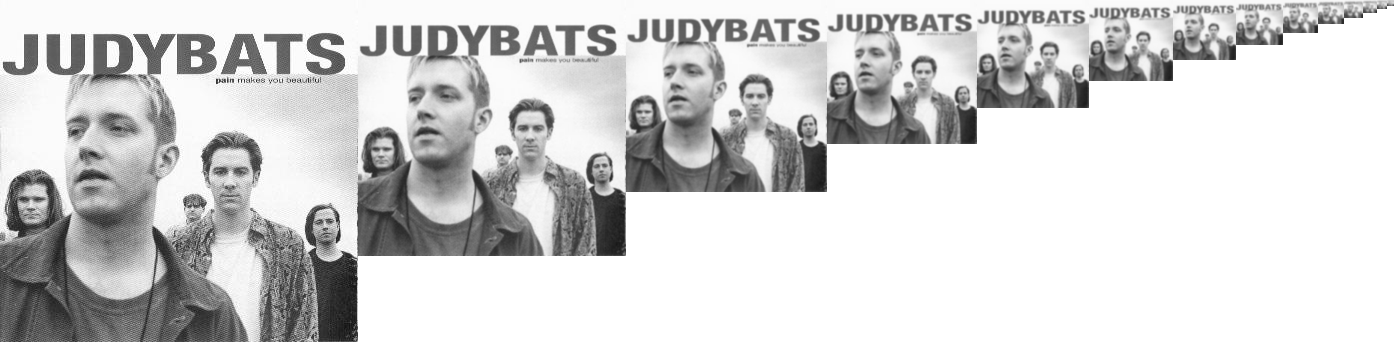

In [ ]:
showGaussianPyramid(pyr)

##4.FindTemplate

In [ ]:
# covert 3d image array to image:
def  covertImage(im_array):
     im_array = im_array.astype('uint8')
     if (len(im_array.shape) == 3 and im_array.shape[2]==1):
         im_array = im_array[:,:,0]
     im = Image.fromarray(im_array)
     return im

def  FindTemplate(pyramid, template, threshold):

     #adjust the template size to fit in the aspect ratio
     t_width = 15
     scale = template.size[0]/15
     t_height = int(template.size[1]//scale)
     template = template.resize((t_width,t_height), Image.BICUBIC)

     #covert original image to colored image
     im_array = pyramid[0]
     
     im = covertImage(im_array).copy().convert("RGB")
     draw = ImageDraw.Draw(im)

     #find the point(centre on each matched image) that corredponding to the value of normalized correlation that is greater than the threshod on each scaled image in pyramid
     for i in range(len(pyramid)):
         pyramid_im = covertImage(pyramid[i])
         normcorr_mtx = ncc.normxcorr2D(pyramid_im, template)

         #find the location of the value that is larger than the threshod
         location = []
         for j in range (len(normcorr_mtx)):
           for k in range (len(normcorr_mtx[0])):
             if normcorr_mtx[j][k] > threshold:
               location.append((k,j))

         # calculate the match result coordinaate (on the original image, need to adjust the template scale by factor of scale0.75)
         for loc in location:
           ratio = (1/0.75)**i
           
           w = int(t_width/2)
           h = int(t_height/2)
           x1 = (loc[0] - w)*ratio
           y1 = (loc[1] -h)*ratio
           x2 = (loc[0] + w)*ratio
           y2 = (loc[1] +h)*ratio

        #draw the match result on the original image
           draw.line((x1,y1,x2,y1),fill="red",width=2)
           draw.line((x1,y1,x1,y2),fill="red",width=2)
           draw.line((x2,y1,x2,y2),fill="red",width=2)
           draw.line((x1,y2,x2,y2),fill="red",width=2)

     del draw
     return im 

     

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


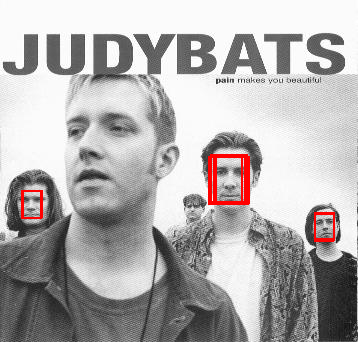

In [ ]:
template = Image.open('/content/drive/MyDrive/cs425/A2/template.jpg')
img = FindTemplate(pyr, template, 0.7)
img.show()
display(img)

##5.Fine the best threshod

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


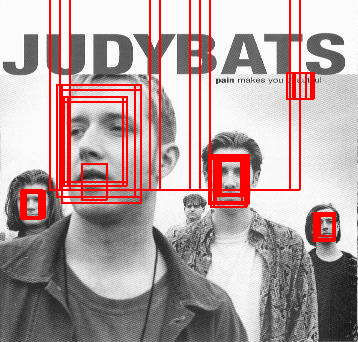

In [ ]:
judybats = Image.open('/content/drive/MyDrive/cs425/A2/judybats.jpg')
students = Image.open('/content/drive/MyDrive/cs425/A2/students.jpg')
tree = Image.open('/content/drive/MyDrive/cs425/A2/tree.jpg')
family = Image.open('/content/drive/MyDrive/cs425/A2/family.jpg')
fans = Image.open('/content/drive/MyDrive/cs425/A2/fans.jpg')
sports = Image.open('/content/drive/MyDrive/cs425/A2/sports.jpg')

#Best threshod: where approximate equal error rate appears
best_threshod = 0.57

img1 = FindTemplate(makeGaussianPyramid(judybats, 0.75, 5), template, best_threshod)
img1.show()
display(img1)

 ##### Number of non-faces seen as faces = 1
 ##### Number of missed faces = 1

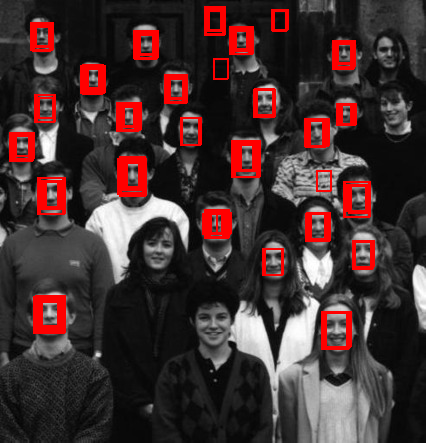

In [ ]:
img2 = FindTemplate(makeGaussianPyramid(students, 0.75, 5), template, best_threshod)
img2.show()
display(img2)

 ##### Number of non-faces seen as faces = 4
 ##### Number of missed faces = 4

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


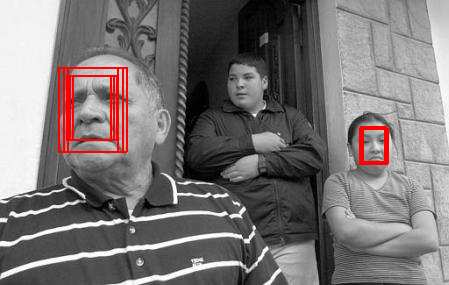

In [ ]:
img3 = FindTemplate(makeGaussianPyramid(family, 0.75, 5), template, best_threshod)
img3.show()
display(img3)

 ##### Number of non-faces seen as faces = 0
 ##### Number of missed faces = 1

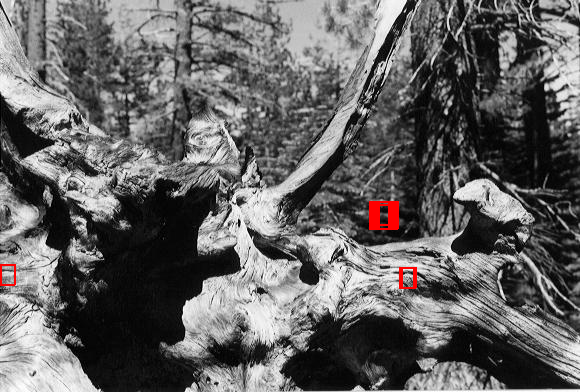

In [ ]:
img4 = FindTemplate(makeGaussianPyramid(tree, 0.75, 5), template, best_threshod)
img4.show()
display(img4)

 ##### Number of non-faces seen as faces = 3
 ##### Number of missed faces = 0

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


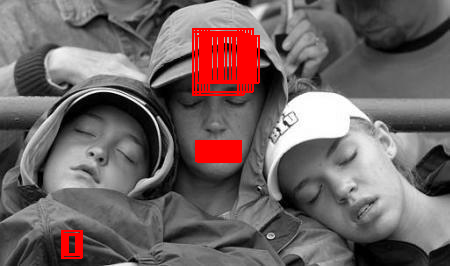

In [ ]:
img5 = FindTemplate(makeGaussianPyramid(fans, 0.75, 5), template, best_threshod)
img5.show()
display(img5)

 ##### Number of non-faces seen as faces = 3
 ##### Number of missed faces = 3

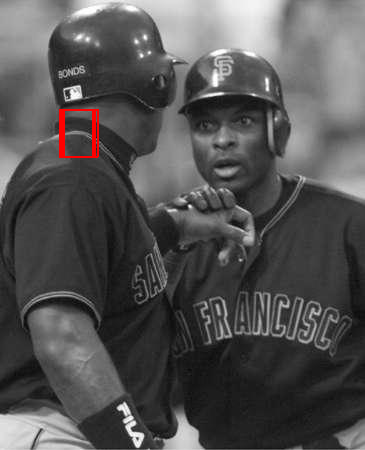

In [ ]:
img6 = FindTemplate(makeGaussianPyramid(sports, 0.75, 5), template, best_threshod)
img6.show()
display(img6)

 ##### Number of non-faces seen as faces = 1
 ##### Number of missed faces = 1

##6. recall rate
According to definition: recall rate: (true positives / relevant elements). The recall rate for each image: (1)judybats: 4/5 (2)students: 22/26 (3)family: 2/3 (4)tree: 0/0(undefined) (5)fans: 0/3 (6)sports: 0/1

#### Explain why the NCC method has a very low recall rate on some images
##### Explanation: 
(1) If there is no faces in the image, then the denominator will automatically be 0 which will lead to undefined value for recall rate (Ex: tree).
(2) The template size does not match the face size on the image (include scaled one). If the template size is much smaller or larger than the size of faces on the image (refers to faces that are much closer or far from the camera, ex:sports, family ), the faces will not be recognized


#Part2: Image Blending
## 2. MakeLaplacianPyramid

In [ ]:
def MakeLaplacianPyramid(image, scale, minsize):
    im = image.copy()
    im = im.convert("RGB")
    lap_pyramid = []
    pyramid = makeGaussianPyramid(image, scale, minsize)
    # for those non-highest level image, calculate the diffence bewteen the original one and the image after apply the gaussian filter and insert in the LaplacianPyramid
    for i in range(len(pyramid) - 1):
        #first convert the image in the pyramid into colored image
        img_original = covertImage(pyramid[i].copy())
        img_original = img_original.convert("RGB")
        img_original = np.asarray(img_original)
        new_img = []
        im = np.asarray(im)
        #apply gaussian filter to each channel and combine them as new blurred image
        for j in range(3):
            new_img.append(gaussian_filter(im[:,:,j], sigma=1/(2*scale)))
        new_img = np.dstack(new_img)

        #caculate the difference:
        
        lop = img_original - new_img
        lop = lop.astype('float')
        #lop = np.clip(lop+128,0,255)
        lap_pyramid.append(lop)

        #resize it to next level
        new_img = new_img.astype('uint8')
        im = Image.fromarray(new_img)
        im = im.resize((int(im.size[0]*scale),int(im.size[1]*scale)), Image.BICUBIC)

    #the highest level is the same as the one in gaussian pyramid
    lap_pyramid.append(pyramid[len(pyramid)-1])
    return lap_pyramid


## 3.ShowLaplacianPyramid

In [ ]:
def ShowLaplacianPyramid(pyramid):
    # initialize the width, height value
    W = 0
    H = 0
    offset_x = 0
    offset_y = 0
    # calculate the width, height for blank canvas
    for im_array in pyramid:
        im_array = im_array.astype('uint8')
        im = Image.fromarray(im_array)
        W += im.size[0]
        H = max(H, im.size[1])
    
    #create the big blank canvas with white background 
    mode = "RGB"
    color=(255,255,255)
    image = Image.new(mode, (W, H),color)

    # Add each image into the blank canvas, and add offset 128 to each image that is non-highest level
    for i in range(len(pyramid)-1):
        im_array = pyramid[i]
        
        im_array = im_array.astype(np.uint8)
        im_array = np.clip(im_array+128,0,255)
        im = Image.fromarray(im_array)
        image.paste(im, (offset_x, offset_y))
        offset_x += im.size[0]

    # add the last highest level image to the big canvas without adding offset 
    im_array = pyramid[len(pyramid)-1]
    im_array = im_array.astype('uint8')
    im = Image.fromarray(im_array)
    image.paste(im, (offset_x, offset_y))
    # image.show()
    # display(image)
    return image



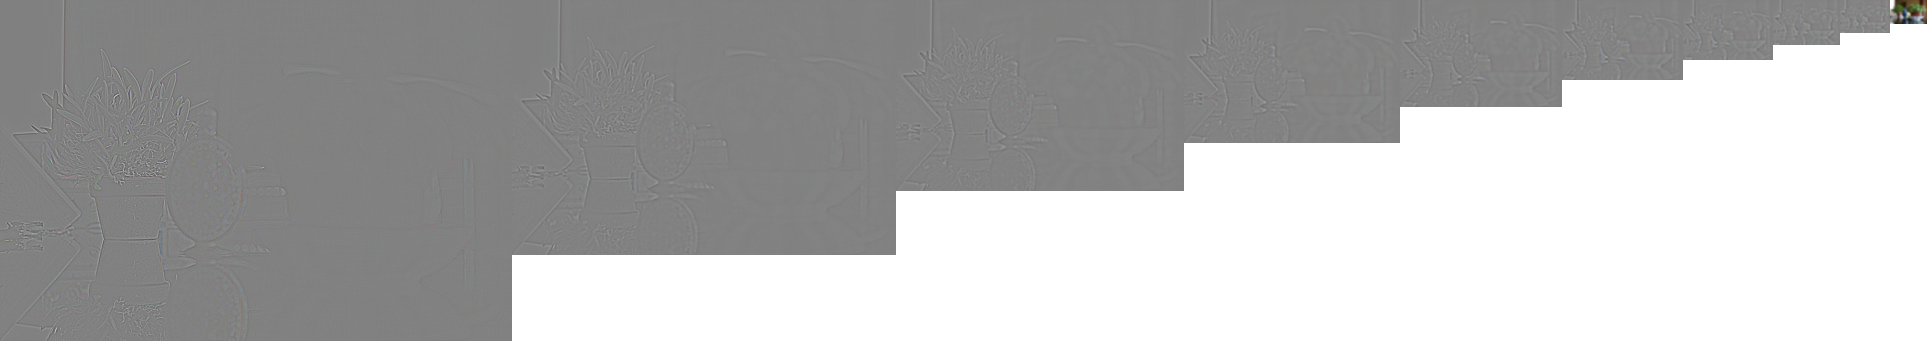

In [ ]:
orchid = Image.open('/content/drive/MyDrive/cs425/A2/orchid.jpg')
violet = Image.open('/content/drive/MyDrive/cs425/A2/violet.jpg')
orchid_pyramid = MakeLaplacianPyramid(orchid, 0.75, 20)
violet_pyramid = MakeLaplacianPyramid(violet, 0.75, 20)
ShowLaplacianPyramid(orchid_pyramid)


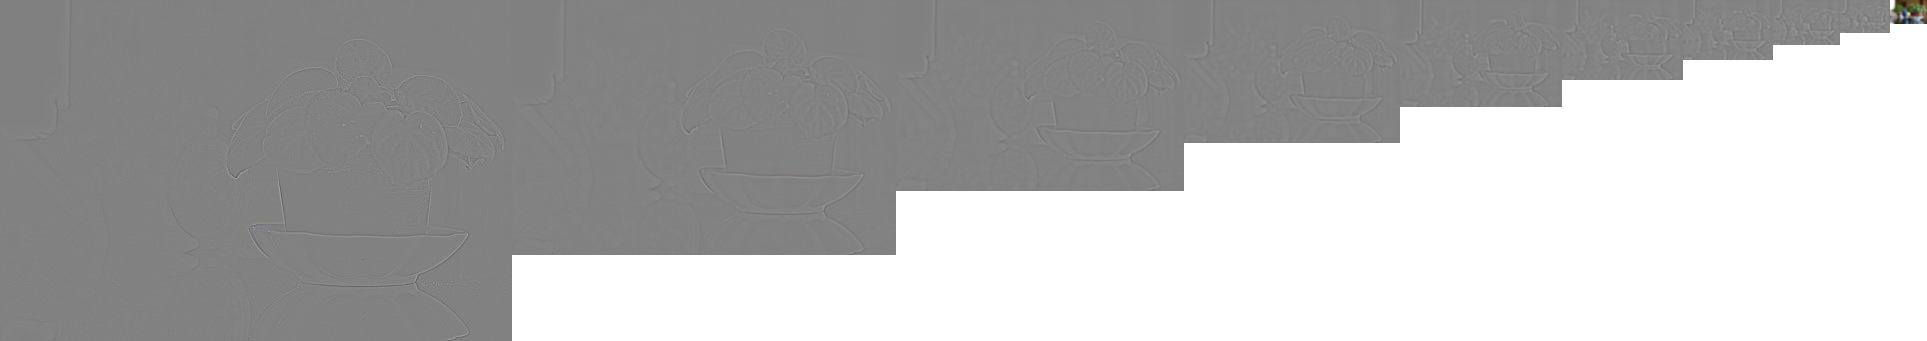

In [ ]:
ShowLaplacianPyramid(violet_pyramid)

## 4.ReconstructGaussianFromLaplacianPyramid

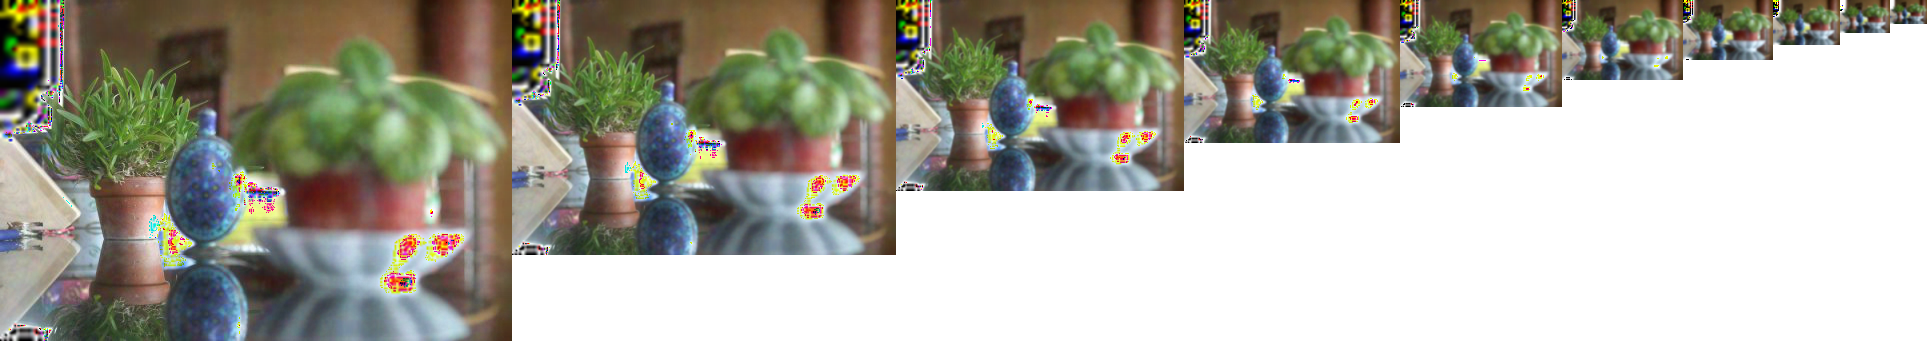

In [ ]:
#may have issue with clip or lose the too much information during transformation between image and array,
#have been debug for a long time, do not know which step went wrong
def reconstructHelper(gpyramid, lPyramid, level):
    #base case, when run out of image in the Ipyramid 
    if (level == 0):
      return
    #base case, start from highest level, need to simply make its copy and insert into new gaussian pyramid
    elif (level == len(lPyramid)):
      im_array = lPyramid[level -1].copy()
      #im_array = np.clip(im_array,0,255)
      gpyramid.append(im_array)
      reconstructHelper(gpyramid, lPyramid, level-1)
    # The other case: first upsample the last element in the new gaussian pyramid, 
    # and then add the current level image in the laplacian pyramid to it, finally add this combined image to the gaussian pyramid
    else:
      #get the last element and upsample it
      g_img = gpyramid[-1].copy()
      l_img = covertImage(lPyramid[level -1].copy())
      size = l_img.size
      #g_img = covertImage(g_img).copy()
      #g_img = g_img.resize(size, Image.BICUBIC)
      g_img = np.array(Image.fromarray(g_img.astype('uint8')).resize(size))
      #g_img = np.asarray(g_img, dtype = "float")
      #g_img = np.clip(g_img-128,-128,128)
      #l_img = np.clip(np.asarray(l_img),-128,128)
      l_img = np.asarray(l_img)
      

      #add the current level image in the laplacian pyramid to it
      new_img = g_img + l_img
      new_img = np.clip(new_img,0,255)
      
      gpyramid.append(new_img)

      #go to the next level
      reconstructHelper(gpyramid, lPyramid, level-1)

    
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
    gpyramid = []
    reconstructHelper(gpyramid, lPyramid, len(lPyramid))
    #print the pyramid in the reverse order (since we save the small resolution image first)
    return gpyramid[::-1]

orchid_gpyramid = ReconstructGaussianFromLaplacianPyramid(orchid_pyramid)
showGaussianPyramid(orchid_gpyramid)

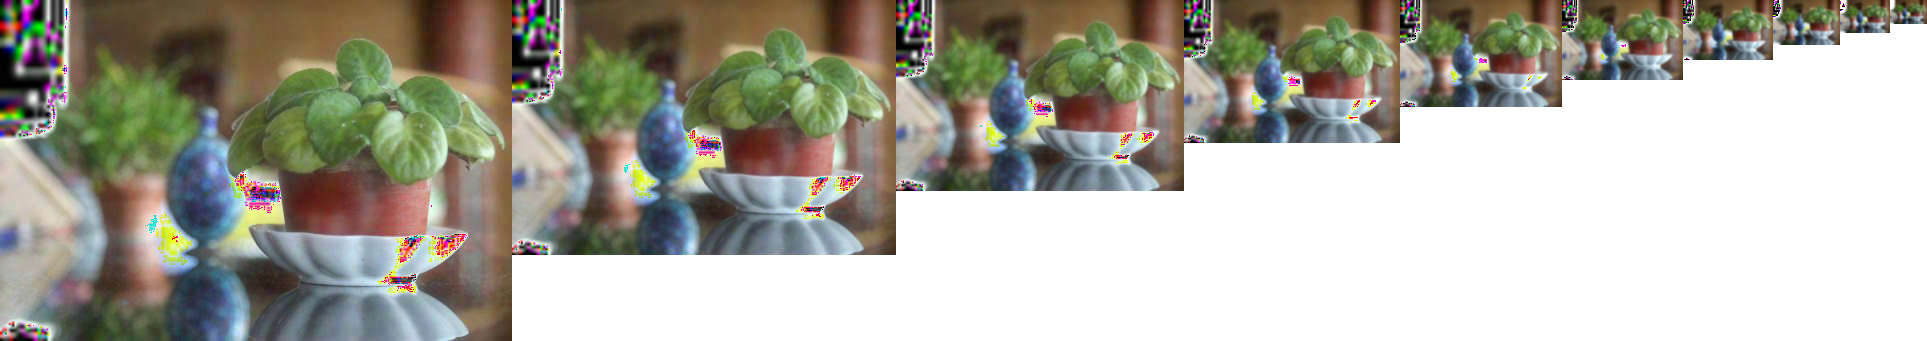

In [ ]:
violet_gpyramid = ReconstructGaussianFromLaplacianPyramid(violet_pyramid)
showGaussianPyramid(violet_gpyramid)

##5.ShowGaussianPyramid

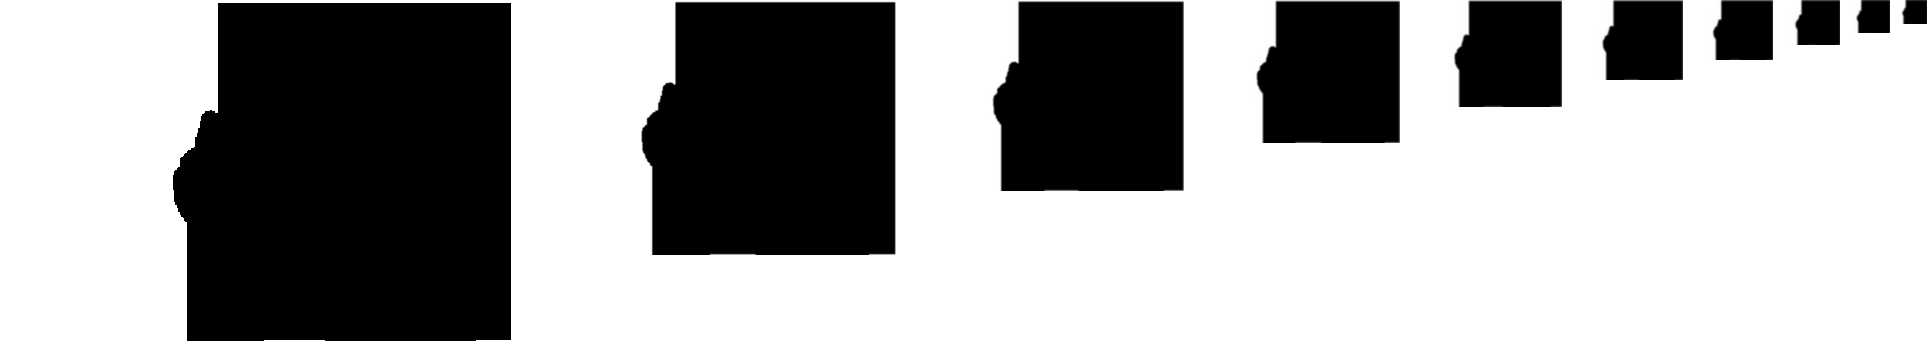

In [ ]:
orchid_mask = Image.open('/content/drive/MyDrive/cs425/A2/orchid_mask.bmp')
orchid_mask_pyramid = makeGaussianPyramid(orchid_mask,0.75,20)
showGaussianPyramid(orchid_mask_pyramid)

##6.Blend

In [ ]:
def blend(lapA,lapB,gaussianM):
  compLaplacian = []
  # compose the two Laplacian pyramids, level by level, using Gaussian pyramid levels as masks (which first normalized to be in the 0 to 1 range)
  # composition are done per color channel
  for i in range(len(lapA)): 
      # calculate the composition for each channel
      lap_a = lapA[i]
      lap_b = lapB[i]
      gaussian_m = gaussianM[i]
      r = lap_a[:,:,0] * gaussian_m[:,:,0]/255 +  lap_b[:,:,0] * (1 - gaussian_m[:,:,0]/255)
      g = lap_a[:,:,1] * gaussian_m[:,:,0]/255 +  lap_b[:,:,1] * (1 - gaussian_m[:,:,0]/255)
      b = lap_a[:,:,2] * gaussian_m[:,:,0]/255 +  lap_b[:,:,2] * (1 - gaussian_m[:,:,0]/255)

      #combine three channel back
      final = np.dstack((r,g,b))
      final = final.astype('float')
      compLaplacian.append(final)
      
  return compLaplacian

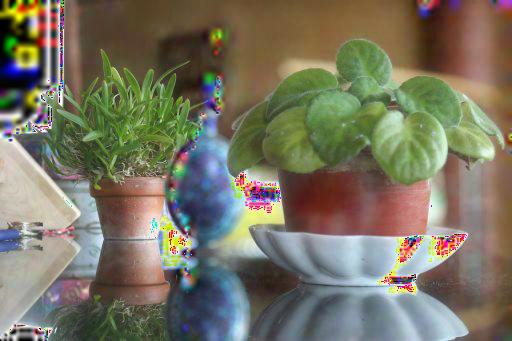

In [ ]:
#print the blend image: orchard-violet
blend_pyramid = blend(orchid_pyramid,violet_pyramid,orchid_mask_pyramid)
recon_pyramid = ReconstructGaussianFromLaplacianPyramid(blend_pyramid)
covertImage(recon_pyramid[0])

##7.Play with Blend

In [109]:
#create the blend image
def generateBlendImage(imgL, imgR, scale, minsize, mask):
    #first: generate lapalcian pyramid for the input image
    lapA = MakeLaplacianPyramid(imgL, scale, minsize)
    lapB = MakeLaplacianPyramid(imgR, scale, minsize)
    #then generate mask pyramid
    mask_pyramid = makeGaussianPyramid(mask, scale, minsize)

    #then blend two images with mask
    blend_pyramid = blend(lapA,lapB,mask_pyramid)
    recon_pyramid = ReconstructGaussianFromLaplacianPyramid(blend_pyramid)
    image = covertImage(recon_pyramid[0]) 
    image.show()
    display(image)




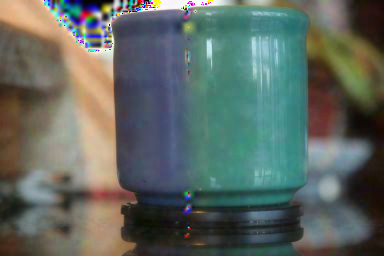

In [110]:
#create the blend image: blue_cup-green_cup
blue_cup = Image.open('/content/drive/MyDrive/cs425/A2/blue_cup.jpg')
green_cup = Image.open('/content/drive/MyDrive/cs425/A2/green_cup.jpg')
blue_green_mask = Image.open('/content/drive/MyDrive/cs425/A2/cup_mask.bmp')
generateBlendImage(blue_cup,green_cup, 0.75, 20, blue_green_mask)

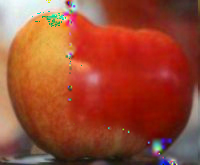

In [111]:
#create the blend image: apple-tomato pairs
apple = Image.open('/content/drive/MyDrive/cs425/A2/apple.jpg')
tomato = Image.open('/content/drive/MyDrive/cs425/A2/tomato.jpg')
apple_tomaato_mask = Image.open('/content/drive/MyDrive/cs425/A2/tomato_mask.bmp')
generateBlendImage(apple, tomato, 0.75,20,apple_tomaato_mask)

